# __Préparation des données pour l’entraînement__


_Le dataset a été exploré dans `01_data_overview.ipynb` (structure, visualisation, valeurs de `labelId`)._
_Ce notebook prépare les données pour l'entraînement sur 8 classes principales, comme précisé dans le brief._

__Rappel et éléments clés__
- Contrairement aux projets précédents orientés classification, ici chaque image est associée à un masque sémantique où chaque pixel porte une étiquette. Cela implique __une gestion rigoureuse des paires (image, masque)__, sans désalignement. 
- Le déséquilibre des classes ne justifie pas un équilibrage par duplication, mais peut être compensé par __une pondération dans la fonction de perte__. Le format `TFRecord` a été choisi pour optimiser les entrées/sorties en CPU, au prix d’un code un peu plus complexe. 
- Le risque de fuite de données est contrôlé en réalisant __les splits avant tout traitement, et en assurant une stricte séparation des villes__ (Cityscapes). 
- Deux modèles seront comparés : un `U-Net` baseline et un modèle avancé type `DeepLabv3+`.


In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
import albumentations as A
import mlflow
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


## __Sommaire__

1. Mapping `labelId → trainId` (8 classes utiles)
2. Resize/crop éventuel des images/masques
3. Conversion en TFRecords ou arrays Numpy et sauvegarde des données “prêtes à l’emploi” dans data/processed/

## 1. __Mapping `labelId → 8 classes`__

Cityscapes fournit :
- 34 classes avec un identifiant (labelId)
- 19 classes "trainables" (recommandées pour l’entraînement)
- Des regroupements possibles selon les besoins métier

In [2]:
# Liste simplifiée des 34 classes Cityscapes (labelId + nom uniquement) - cityscapesscripts/helpers/labels.py
cityscapes_classes = [
    (  0, 'unlabeled'),
    (  1, 'ego vehicle'),
    (  2, 'rectification border'),
    (  3, 'out of roi'),
    (  4, 'static'),
    (  5, 'dynamic'),
    (  6, 'ground'),
    (  7, 'road'),
    (  8, 'sidewalk'),
    (  9, 'parking'),
    ( 10, 'rail track'),
    ( 11, 'building'),
    ( 12, 'wall'),
    ( 13, 'fence'),
    ( 14, 'guard rail'),
    ( 15, 'bridge'),
    ( 16, 'tunnel'),
    ( 17, 'pole'),
    ( 18, 'polegroup'),
    ( 19, 'traffic light'),
    ( 20, 'traffic sign'),
    ( 21, 'vegetation'),
    ( 22, 'terrain'),
    ( 23, 'sky'),
    ( 24, 'person'),
    ( 25, 'rider'),
    ( 26, 'car'),
    ( 27, 'truck'),
    ( 28, 'bus'),
    ( 29, 'caravan'),
    ( 30, 'trailer'),
    ( 31, 'train'),
    ( 32, 'motorcycle'),
    ( 33, 'bicycle')
]

# Affichage propre en DataFrame Pandas
import pandas as pd
df_cityscapes = pd.DataFrame(cityscapes_classes, columns=["labelId", "name"])
display(df_cityscapes.head(10))


,labelId,name
0,0,unlabeled
1,1,ego vehicle
2,2,rectification border
3,3,out of roi
4,4,static
5,5,dynamic
6,6,ground
7,7,road
8,8,sidewalk
9,9,parking


Voici les 8 classes principales  avec les labelId associés
| ID regroupé | Nom de la classe           | `labelId` inclus                            | Raison métier principale                         |
|-------------|-----------------------------|---------------------------------------------|--------------------------------------------------|
| 0           | __road__                    | 7                                           | Surface de conduite                             |
| 1           | __sidewalk__                | 8                                           | Bordures à prendre en compte                    |
| 2           | __construction__         | 11, 12, 13                                      | Décor statique urbain                           |
| 3           | __object__           | 17, 19, 20                                      | Feux & panneaux à interpréter                   |
| 4           | __nature__    | 21, 22                                      | Fond ou obstacle naturel                        |
| 5           | __sky__                     | 23                                          | Contexte visuel (utile pour segmentation)       |
| 6           | __human__          | 24, 25                                      | Objets mobiles critiques                        |
| 7           | __vehicle__                | 26, 27, 28, 31, 32, 33                      | Voitures, bus, moto, vélo, etc. à éviter        |

__Notes importantes__ :  
- Tous les autres `labelId` (0 à 6, 9, 10, 14–16, 18, 29 et 30) seront __ignorés__ → on les mappe à `255` (valeur "void").

In [3]:
LABELID_TO_8CLASS = {
    7: 0,    # road
    8: 1,    # sidewalk
    11: 2, 12: 2, 13: 2,     # construction elements
    17: 3, 19: 3, 20: 3,     # objects
    21: 4, 22: 4,            # vegetation + terrain
    23: 5,                  # sky
    24: 6, 25: 6,            # person & rider
    26: 7, 27: 7, 28: 7, 31: 7, 32: 7, 33: 7  # vehicles
}

def map_to_8_classes(label_mask, mapping):
    new_mask = np.ones_like(label_mask, dtype=np.uint8) * 255  # classe ignorée
    for label_id, class_8 in mapping.items():
        new_mask[label_mask == label_id] = class_8
    return new_mask

Exemple d'utilisation possible ....

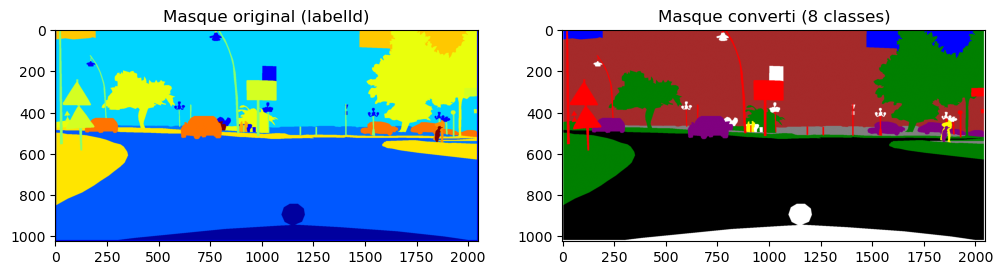

In [4]:

path_mask = "../data/raw/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png"
label_mask = cv2.imread(path_mask, cv2.IMREAD_UNCHANGED)
converted_mask = map_to_8_classes(label_mask, LABELID_TO_8CLASS)

# Affichage des masques avant/après mapping
cmap = ListedColormap(['black', 'gray', 'brown', 'red', 'green', 'blue', 'yellow', 'purple', 'white'])  # 8 classes + ignore
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(label_mask, cmap='jet', vmin=0, vmax=33)
ax[0].set_title('Masque original (labelId)')
ax[1].imshow(converted_mask, cmap=cmap, vmin=0, vmax=8)
ax[1].set_title('Masque converti (8 classes)')
plt.show()

In [5]:
# Construction du dictionnaire des 8 classes métiers
data_8class = [
    (0, "Surfaces planes", [7, 8]),
    (1, "Constructions", [11, 12]),
    (2, "Objets, obstacles", [19, 20]),
    (3, "Environnement", [21, 22]),
    (4, "Ciel", [23]),
    (5, "Humains", [24, 25]),
    (6, "Véhicules", [26, 27, 28, 31, 32, 33]),
    (255, "Ignoré", None)
]

df_8class = pd.DataFrame(data_8class, columns=["class_id", "nom_metier", "labelIds_inclus"])

# Création du dossier si besoin
os.makedirs("../data/dictionaries", exist_ok=True)

# Export
df_8class.to_csv("../data/dictionaries/classes_8_mapping.csv", index=False)

# Confirmation
print("Dictionnaire des 8 classes exporté avec succès ;-)")
df_8class



Dictionnaire des 8 classes exporté avec succès ;-)


,class_id,nom_metier,labelIds_inclus
0,0,Surfaces planes,"[7, 8]"
1,1,Constructions,"[11, 12]"
2,2,"Objets, obstacles","[19, 20]"
3,3,Environnement,"[21, 22]"
4,4,Ciel,[23]
5,5,Humains,"[24, 25]"
6,6,Véhicules,"[26, 27, 28, 31, 32, 33]"
7,255,Ignoré,None


## 2. __Resize__

__Pourquoi redimensionner les images et les masques ?__

Le futur modèle `U-Net` (ou `DeepLabV3+`) attend des images de taille uniforme, généralement un multiple de 32 (comme 256x512, 512x1024, etc.)

Nous allons ainsi :
- Créer des __images redimensionnées__ uniformément,
- Conserver des __masques convertis en 8 classes__, avec une interpolation adaptée,
- Les __sauvegarder proprement__ dans l'arborescence `data/processed/`.

| Élément    | Interpolation                | Format de sortie | Dossier cible                    |
| ---------- | ---------------------------- | ---------------- | -------------------------------- |
| __Image__  | `cv2.INTER_LINEAR`           | `.png` ou `.npy` | `data/processed/images_256x512/` |
| __Masque__ | `cv2.INTER_NEAREST` (obligé) | `.png` ou `.npy` | `data/processed/masks_256x512/`  |


In [6]:
# Fonction de redimensionnement et sauvegarde

def resize_and_save(image_path, mask_path, output_dir_img, output_dir_mask, size=(256, 512)):
    """
    Redimensionne une image et son masque associé, puis les sauvegarde dans des dossiers distincts.
    """
    # Charger l'image (RGB)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Charger le masque (uint8 brut labelId)
    label_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    # Convertir le masque en 8 classes
    converted_mask = map_to_8_classes(label_mask, LABELID_TO_8CLASS)

    # Resize
    image_resized = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
    mask_resized = cv2.resize(converted_mask, size, interpolation=cv2.INTER_NEAREST)

    # Préparer les noms
    name = os.path.basename(image_path).replace("_leftImg8bit.png", "")
    img_out_path = os.path.join(output_dir_img, f"{name}.png")
    mask_out_path = os.path.join(output_dir_mask, f"{name}_mask.png")

    # Créer les dossiers si besoin
    os.makedirs(output_dir_img, exist_ok=True)
    os.makedirs(output_dir_mask, exist_ok=True)
    
    # Enregistrer sur disque
    # Attention : OpenCV attend BGR pour l'image
    cv2.imwrite(img_out_path, cv2.cvtColor(image_resized, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_out_path, mask_resized)


In [7]:
# Traitement de tous les splits
def process_all_splits(
    root_images="../data/raw/leftImg8bit",
    root_masks="../data/raw/gtFine",
    out_img_root="../data/processed/images_256x512",
    out_mask_root="../data/processed/masks_256x512",
    size=(256, 512)
):
    splits = ['train', 'val', 'test']
    for split in splits:
        print(f"\n Traitement split : {split}")

        split_img_dir = os.path.join(root_images, split)
        split_mask_dir = os.path.join(root_masks, split)

        for city in os.listdir(split_img_dir):
            img_city_dir = os.path.join(split_img_dir, city)
            mask_city_dir = os.path.join(split_mask_dir, city)

            for filename in os.listdir(img_city_dir):
                if filename.endswith("_leftImg8bit.png"):
                    name_base = filename.replace("_leftImg8bit.png", "")
                    img_path = os.path.join(img_city_dir, filename)
                    mask_path = os.path.join(mask_city_dir, f"{name_base}_gtFine_labelIds.png")

                    # Sortie
                    out_img_dir = os.path.join(out_img_root, split)
                    out_mask_dir = os.path.join(out_mask_root, split)

                    try:
                        resize_and_save(
                            img_path, mask_path,
                            out_img_dir, out_mask_dir,
                            size
                        )
                    except Exception as e:
                        print(f" Erreur avec {img_path} : {e}")


In [8]:
process_all_splits()



 Traitement split : train

 Traitement split : val

 Traitement split : test


In [9]:
from pathlib import Path
print(len(list(Path("../data/processed/images_256x512/train").rglob("*.png"))))


2975


## 3. __Conversion en TFRecords__

Un TFRecord est un format de fichier binaire optimisé spécialement pour TensorFlow.
Il permet de stocker plein d’exemples (images, masques, labels…) dans un seul fichier compact et rapide à lire. Parfait pour gérer une grande quantité de données et parfaitement compatible avec notre environnement actuel.

In [10]:
# Conversion en TFRecords
from tqdm import tqdm

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(image, mask):
    feature = {
        "image": _bytes_feature(image),
        "mask": _bytes_feature(mask)
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


In [ ]:

def convert_to_tfrecords(img_dir, mask_dir, output_path):
    image_filenames = sorted(os.listdir(img_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    assert len(image_filenames) == len(mask_filenames), "Image et masque : tailles différentes !"

    with tf.io.TFRecordWriter(output_path) as writer:
        for img_name, mask_name in tqdm(zip(image_filenames, mask_filenames), total=len(image_filenames)):
            # Lecture
            img_path = os.path.join(img_dir, img_name)
            mask_path = os.path.join(mask_dir, mask_name)

            image = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # attention : mask = uint8 avec classes

            # Vérification
            if image is None or mask is None:
                print(f"⚠️ Fichier manquant ou corrompu : {img_name}")
                continue

            # Conversion en bytes
            image_bytes = tf.io.encode_png(image).numpy()
            
            # Ajouter une dimension au masque
            mask = np.expand_dims(mask, axis=-1)  # (H, W) → (H, W, 1)
            mask_bytes = tf.io.encode_png(mask).numpy()

            example = serialize_example(image_bytes, mask_bytes)
            writer.write(example)

    print(f"TFRecord créé ({output_path}) avec {len(image_filenames)} exemples.")



In [14]:
# Conversion des splits en TFRecords
# Dossier de sortie
os.makedirs("../data/processed/tfrecords", exist_ok=True)

# Création pour train / val / test
splits = ["train", "val", "test"]
for split in splits:
    img_dir = f"../data/processed/images_256x512/{split}"
    mask_dir = f"../data/processed/masks_256x512/{split}"
    tfrecord_path = f"../data/processed/tfrecords/{split}.tfrecord"

    convert_to_tfrecords(img_dir, mask_dir, tfrecord_path)


100%|██████████| 2975/2975 [01:41<00:00, 29.30it/s]


TFRecord créé : ../data/processed/tfrecords/train.tfrecord


100%|██████████| 500/500 [00:17<00:00, 28.91it/s]


TFRecord créé : ../data/processed/tfrecords/val.tfrecord


100%|██████████| 1525/1525 [00:55<00:00, 27.59it/s]

TFRecord créé : ../data/processed/tfrecords/test.tfrecord


## Résumé — Préparation des données

- Téléchargement et extraction des données `Cityscapes`
- Mapping des 34 classes officielles vers 8 classes métiers
- Resize des images et masques à `256×512`
- Exportation des images et masques en format `TFRecords` pour train, validation, et test.  

Les données sont prêtes pour être utilisées dans un pipeline `tf.data.Dataset`.  

__Pourquoi utiliser TFRecords ?__

- Optimisation des temps d’accès disque
- Lecture en streaming (idéal pour CPU)
- Structure unifiée : chaque fichier contient image + masque
- Compatible avec `tf.data.Dataset` et `Keras` directement.  

⚠️ La normalisation et l’augmentation seront appliquées __plus tard__, au moment de la modélisation.  

__Prochaine étape : Créer un pipeline `tf.data.Dataset`__  

Nous allons :
- Lire les fichiers `.tfrecord`
- Les décoder en images et masques
- Appliquer une normalisation
- Ajouter des augmentations (flip, crop, etc.)
- Préparer les données pour l'entraînement des modèle
